# Neural Machine Translation

In [2]:
from keras.layers import Bidirectional, Concatenate # to concatenate the outputs of the multiple layers along a specified axis. To combine the information from different sources
from keras.layers import LSTM, Multiply, Dot, Input, Permute # too re arrnge he order of the dimension
from keras.layers import Dense, Activation, Lambda, RepeatVector # repeats the input tensor a specified number of times along a specified axis. to replicate the context vector before feeding into the decoder

from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model

import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from babel.dates import format_date

from nmt_utils import *

2023-09-08 10:58:40.798074: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-08 10:58:40.799353: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 10:58:40.829990: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 10:58:40.830456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 10:58:41.478312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Translating human readable dates into Machine redable date

In [3]:
m = 10000 # size of dataset
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 34723.68it/s]


In [4]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('08 jul 2008', '2008-07-08'),
 ('8 sep 1999', '1999-09-08'),
 ('thursday january 1 1981', '1981-01-01')]

In [5]:
# dataset - tuples of human and machine readable data
# human_vocab - dict, char in human redable dates to and int
# machine_vocab - dict, char in machine readable dates to int
# inv_machine_vocab - inverse dict of machine_vocab

In [6]:
Tx = 30 # max input length
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)
# X, Y - processed version of human and Mahine readable dates
# Xoh, Y0h - On-hot version 
X.shape, Y.shape, Xoh.shape, Yoh.shape

((10000, 30), (10000, 10), (10000, 30, 37), (10000, 10, 11))

In [7]:
index = 0
dataset[index][0], dataset[index][1]

('9 may 1998', '1998-05-09')

In [8]:
X[index], Y[index]

(array([12,  0, 24, 13, 34,  0,  4, 12, 12, 11, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]),
 array([ 2, 10, 10,  9,  0,  1,  6,  0,  1, 10]))

In [9]:
Xoh[index], Yoh[index]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32),
 array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32))

### Attention Mechanism

In [10]:
## We use pre-attentions Bi-LSTM with Tx steps and post-attention Bi-LSTM with Ty steps
## In the post-attention Bi-LSTM, we pass s_t (output activation) and c_t (hidden cell state) and at time t, it does not take y_(t-1) as input, it only takes s_t and c_t. Because the date is not dependent of the previous character
## a_t to represent the cocatenation of the both forward-direction and backward-direction
## It uses RepeatVector node to copy s_(t-1)'s value Tx times and then Concatenation to concatenate s_(t-1) and a_t to compute e_(t, t')

$$context^{<t>} = \sum_{t' = 1}^{T_x} \alpha^{<t,t'>}a^{<t'>}\tag{1}$$ 


In [11]:
repeater  = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)

densor1 = Dense(10, activation="tanh")
densor2 = Dense(1, activation="relu")

activator = Activation(softmax, name = 'attention_weights') # custom softmax layer

dotor = Dot(axes=1)

In [12]:
## given all the hidden states of the Bi-LSTM [a_1, a_2, a_3.....a_Tx] and the  prev hidden state of the second LSTM s_(t-1)
# This will compute the attention_weights alpha_(t, 1), alpha(t, 2), ..... and the output the context vectorc_t

def one_Step_attention(a, s_prev):
    # outputs context vector computed as a dot product of the attention and the hiddent state of the Bi_LSTM
    # performs one step of attention
    
    # to repeat the s_prv to be the shape of the (m, Tx, n_s) so that concatenate it with all hiddent states2
    s_prev = repeater(s_prev) # to repeat the previous hidden layer for time step in the input sequence
    concat = concatenator([a, s_prev]) # cncatenate laong the lat axis, -1
    # applies the no linear transformation to the concatenated layer
    e = densor1(concat)
    # relu and for getting the e_t prime
    energies = densor2(e)
    # calculate the attention parameters
    alphas = activator(energies)
    # calculate the context vector 
    context = dotor([alphas, a])
    
    # returns context vector, input of the next post-attention LSTM cell
    return context

In [13]:
n_a = 32
n_s = 64

post_activation_LSTM_cell =LSTM(n_s, return_state=True)
output_layer = Dense(len(machine_vocab), activation=softmax)

2023-09-08 10:58:43.225646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-08 10:58:43.226093: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
# GRADED FUNCTION: model

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    ### START CODE HERE ###
    
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True),input_shape=(m, Tx, n_a*2))(X)  
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_Step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context,initial_state = [s, c] ) 
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

In [15]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [16]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 37)]             0         []                            
                                                                                                  
 s0 (InputLayer)             [(None, 64)]                 0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 30, 64)               17920     ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 repeat_vector (RepeatVecto  (None, 30, 64)               0         ['s0[0][0]',              

In [17]:
opt = Adam(learning_rate=0.5, beta_1=0.9, beta_2=0.999, weight_decay=0.01) 
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])


In [18]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [19]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

100/100 [==============================] - 14s 28ms/step - loss: 29.0472 - dense_2_loss: 1.8951 - dense_2_1_loss: 2.1023 - dense_2_2_loss: 3.3982 - dense_2_3_loss: 3.8697 - dense_2_4_loss: 2.5195 - dense_2_5_loss: 2.3506 - dense_2_6_loss: 3.7969 - dense_2_7_loss: 2.3183 - dense_2_8_loss: 2.8711 - dense_2_9_loss: 3.9255 - dense_2_accuracy: 0.4667 - dense_2_1_accuracy: 0.4876 - dense_2_2_accuracy: 0.1460 - dense_2_3_accuracy: 0.0446 - dense_2_4_accuracy: 0.6238 - dense_2_5_accuracy: 0.1679 - dense_2_6_accuracy: 0.0391 - dense_2_7_accuracy: 0.6481 - dense_2_8_accuracy: 0.0824 - dense_2_9_accuracy: 0.0364


In [20]:
model.load_weights('models/model.h5')

In [24]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    #print(source)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = np.swapaxes(source, 0, 1)
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    print("source:", example)
    print("output:", ''.join(output),"\n")

1/1 [==============================] - 0s 17ms/step
source: 3 May 1979
output: 1979-05-33 

1/1 [==============================] - 0s 17ms/step
source: 5 April 09
output: 2009-04-05 

1/1 [==============================] - 0s 18ms/step
source: 21th of August 2016
output: 2016-08-20 

1/1 [==============================] - 0s 19ms/step
source: Tue 10 Jul 2007
output: 2007-07-10 

1/1 [==============================] - 0s 21ms/step
source: Saturday May 9 2018
output: 2018-05-09 

1/1 [==============================] - 0s 20ms/step
source: March 3 2001
output: 2001-03-03 

1/1 [==============================] - 0s 17ms/step
source: March 3rd 2001
output: 2001-03-03 

1/1 [==============================] - 0s 22ms/step
source: 1 March 2001
output: 2001-03-01 



1/1 [==============================] - 2s 2s/step


<Figure size 640x480 with 0 Axes>

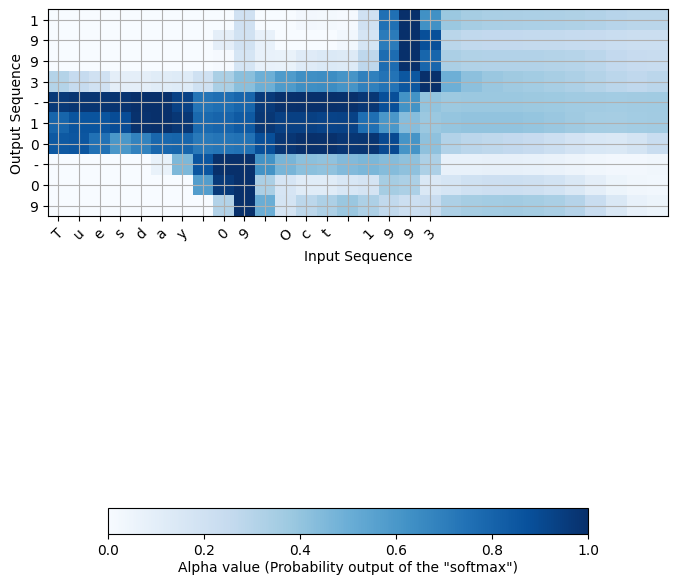

In [ ]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)